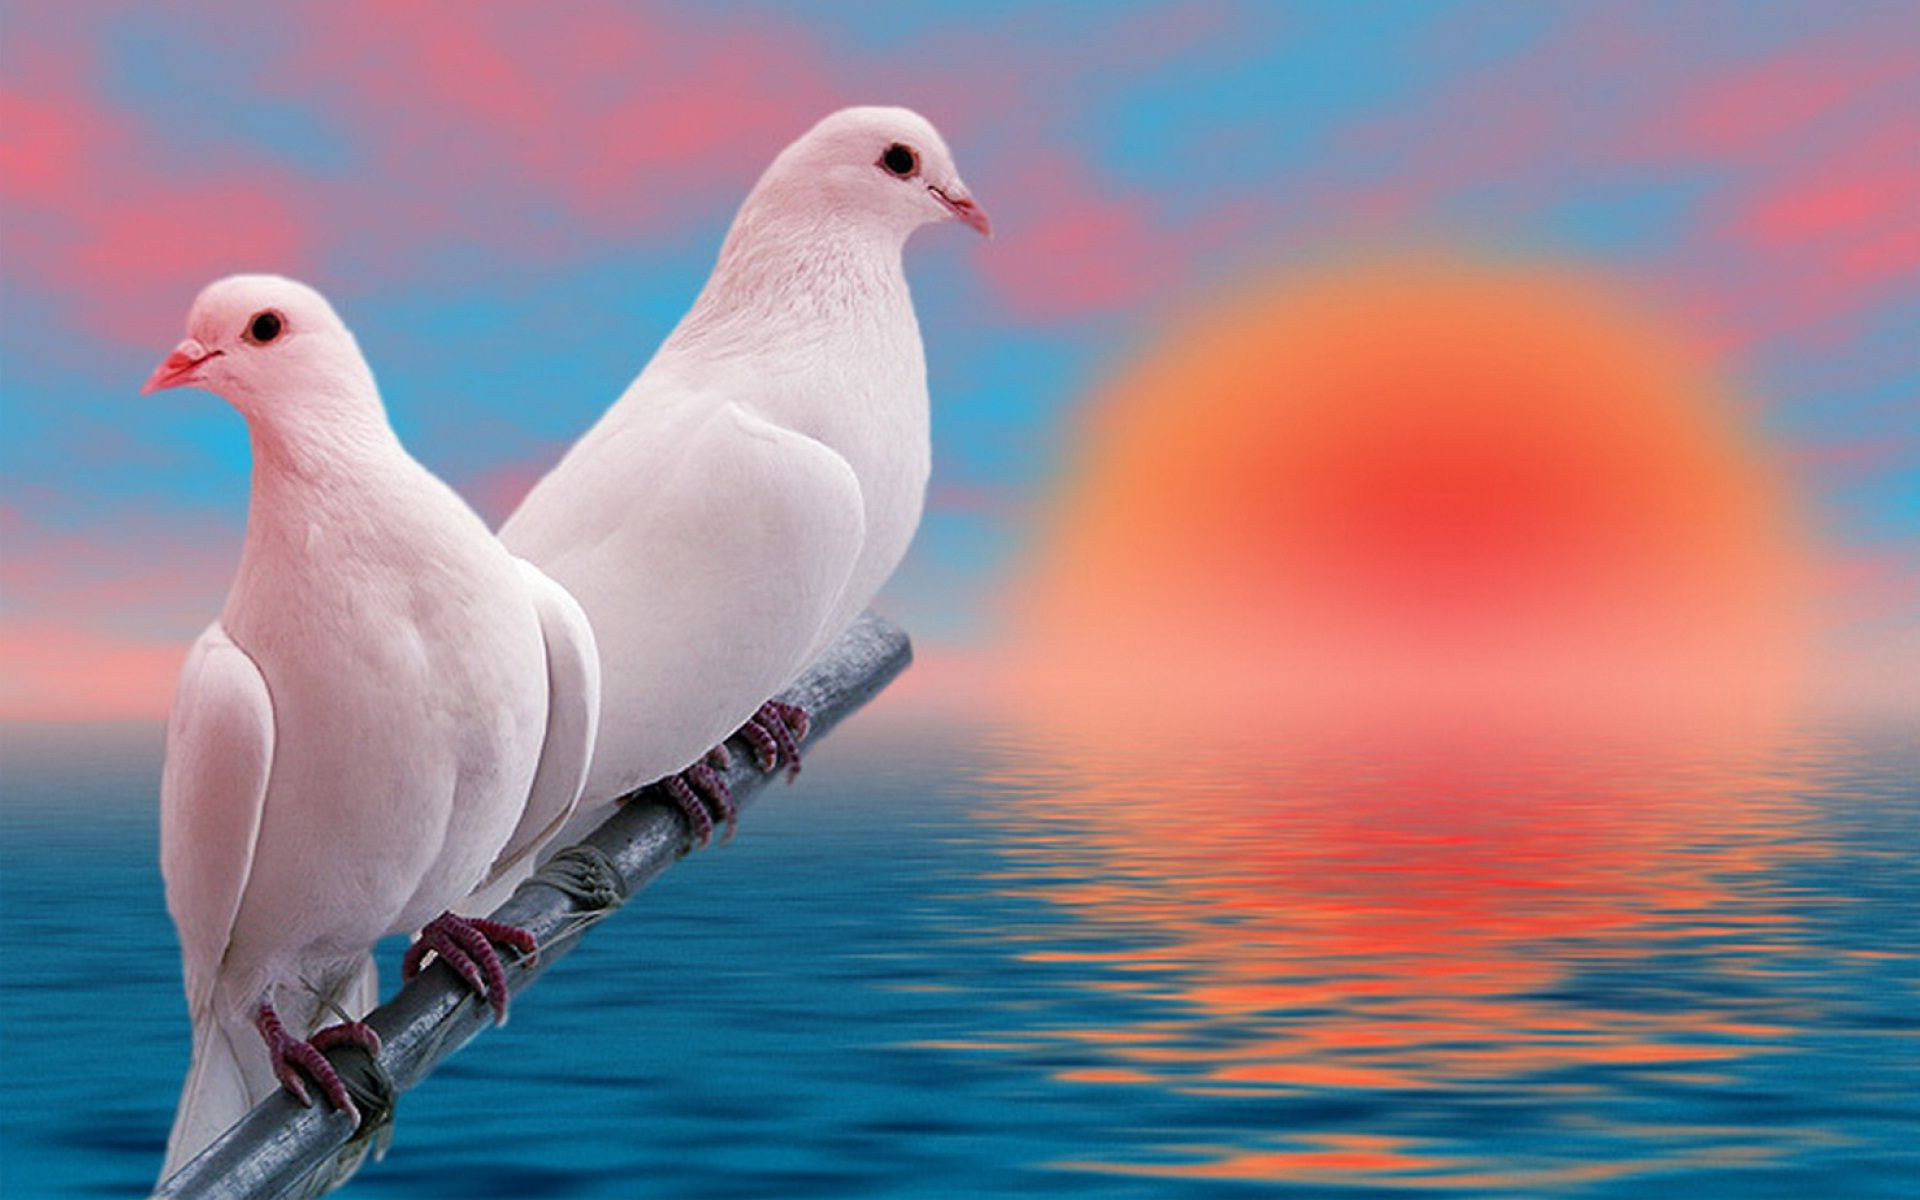

In [1]:
import glob, os
import math
from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance
from PIL import PSDraw
from PIL import ImageFilter
from IPython.display import display
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
 

im = Image.open("orig/img3.jpg")
#im2 = Image.open("img2.jpg")
box = (0, 0, 1920, 1200)
#im2 = im2.crop(box)
display(im)


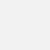

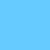

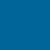

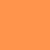

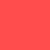

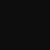

In [2]:
target_colors = [(242, 242, 242), (102, 204, 255), (0, 102, 153), (255, 148, 77), (255, 77, 77), (13, 13, 13)]
for color in target_colors:
    tmp_im = Image.new("RGB", (50, 50), color)
    display(tmp_im)

In [3]:
def pix_distance(x, y):
    return (pow((x[0]-y[0]), 2) + pow((x[1]-y[1]), 2) + pow((x[2]-y[2]), 2))

def find_proper_pixel(pixel, target_pixels):
    dist = []
    for pix in target_pixels:
        dist.append(pix_distance(pixel, pix))
    return dist.index(min(dist))

def split_img_in_colors(im, target_colors): 
    data = im.getdata()
    out_data = []
    out = Image.new("RGB", im.size)
    max_pix = 0
    for pixel in data:
        max_pix = target_colors[find_proper_pixel(pixel, target_colors)]
        out_data.append(max_pix)
    out = Image.new("RGB", im.size)
    out.putdata(out_data)
    return out

def get_separate_colors(im, target_colors):
    data = im.getdata()
    out_data = [[]];
    out = [[]];
    for i in range(len(target_colors) - 1):
        out_data.append([])
        out.append([])
    max_pix = 0
    for pixel in data:
        max_pix = target_colors[find_proper_pixel(pixel, target_colors)]
        for i in range(0, len(target_colors)):
            if target_colors[i] == max_pix:
                out_data[i].append(max_pix)
            else:
                out_data[i].append((255,255,255))
    for i in range(0, len(target_colors)):        
        out[i] = Image.new("RGB", im.size)
        out[i].putdata(out_data[i])
    return out

def get_color_edge(im, rgb):
    out_im = []
    for i in range(len(im)):
        edge = im[i].filter(ImageFilter.FIND_EDGES)
        data = edge.getdata()
        out_data = []
        for pix in data:
            if pix_distance(pix, (0,0,0)) > 10 :
                out_data.append(rgb)
            else:
                out_data.append((255,255,255))
        out = Image.new("RGB", im[i].size)
        out.putdata(out_data)
        out_im.append(out)
    return out_im

def find_color_edges(im, target_colors):
    merged_colors = split_img_in_colors(im, target_colors)
    merged_colors_smooth = merged_colors.filter(ImageFilter.ModeFilter(size = 20))
    
    separate_clrs_pics = get_separate_colors(merged_colors_smooth, target_colors)
    edges = get_color_edge(separate_clrs_pics, (255, 0, 0))
    for i in range(len(edges)):
        edges[i].save("output/" + str(i)+".jpg", "JPEG")
    return edges, merged_colors, merged_colors_smooth, separate_clrs_pics

def find_pix_inside(contour):
    find_point = 0
    i = 0
    inside_pix = []
    while find_point == 0 and i < len(contour):
        base_point = contour[i]
        same_x = [p for p in contour if p[0] == base_point[0] and p[1] != base_point[1]]
        if len(same_x) != 1:
            i += 1
        else:
            inside_pix = [int(same_x[0][0]), int((same_x[0][1] + base_point[1])/2)]
            find_point = 1
    return inside_pix

def show_edge(edge):
    %matplotlib inline
    from matplotlib import axes
    plt.figure(figsize=(20, 10))
    axes = plt.gca()
    axes.set_xlim([0, 1920])
    axes.set_ylim([0, 1200])
    for n, contour in enumerate(edge):
        plt.plot(contour[:, 1], 1200 - contour[:, 0], linewidth=0.5)

In [4]:
edges, merged_colors, merged_colors_smooth, separate_clrs_pics = find_color_edges(im, target_colors)

In [14]:
merged_colors_smooth.show()

In [13]:
from scipy import misc
from skimage import color
from skimage import measure
import matplotlib.pyplot as plt
from dxfwrite import DXFEngine as dxf

pic_name = []
dxf_name = []
all_edges = []
for i in range(len(target_colors)):
    pic_name = ("output/" + str(i) + ".jpg")
    dxf_name = ("output/" + str(i) + ".dxf")
    fimg = misc.imread(pic_name)
    gimg = color.colorconv.rgb2grey(fimg)
    contours = measure.find_contours(gimg, 0.8)
    dxf_edges = dxf.drawing(dxf_name)
    
    data = np.array(separate_clrs_pics[i])
    cut_edges = []
    for contour in contours:
        inside_pix = find_pix_inside(contour)
        if len(inside_pix) > 0:
            if (data[inside_pix[0]][inside_pix[1]] != (255, 255 ,255)).any():
                cut_edges.append(contour)
    
    for n, edge in enumerate(cut_edges):    
        for p1, p2 in zip(edge[0::1], edge[1::1]):
            dxf_edges.add(dxf.line(p1, p2, color=7))
    dxf_edges.add(dxf.line((0,0), (0,1920) , color=7))
    dxf_edges.add(dxf.line((0,1920), (1200,1920) , color=7))
    dxf_edges.add(dxf.line((1200,1920), (1200,0) , color=7))
    dxf_edges.add(dxf.line((1200,0), (0,0) , color=7))
    dxf_edges.save()
    all_edges.append(cut_edges)

/Users/nikita/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]


In [351]:
separate_clrs_pics[4].show()

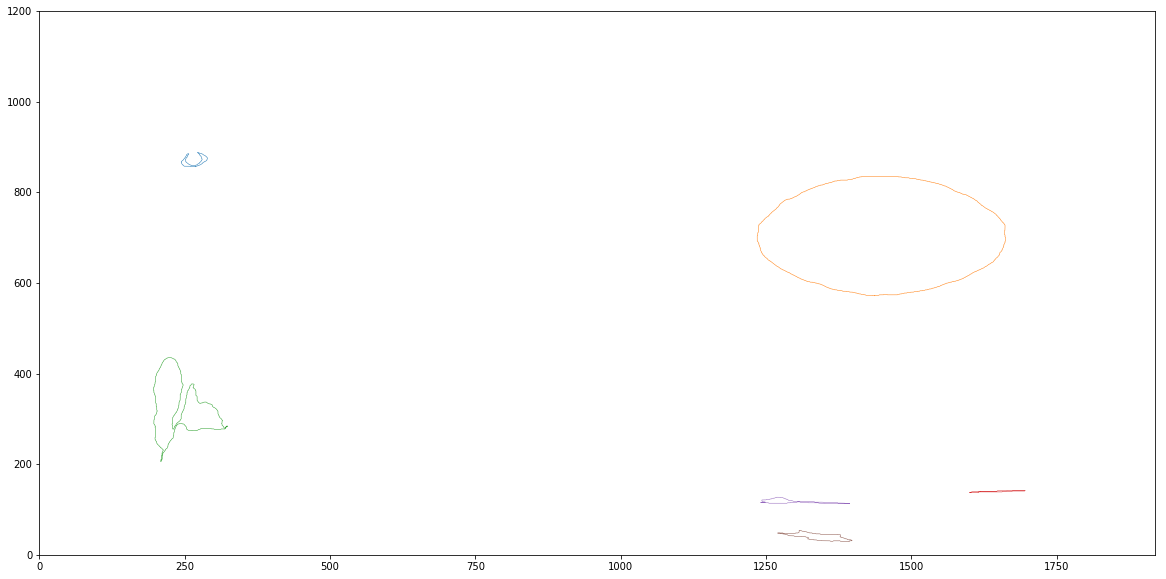

In [357]:
%matplotlib inline
#from matplotlib import axes
plt.figure(figsize=(20, 10))
axes = plt.gca()
axes.set_xlim([0, 1920])
axes.set_ylim([0, 1200])
for c in all_edges[4]:
    if len(c) > 200:
        plt.plot(c[:, 1], 1200 - c[:, 0], linewidth=0.5)
#show_edge(all_edges[4])

In [358]:
merged_colors_smooth.show()

/Users/nikita/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


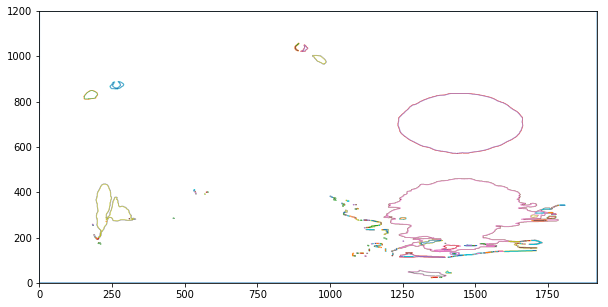

In [325]:
data = np.array(separate_clrs_pics[4])
fimg = misc.imread("output/4.jpg")
gimg = color.colorconv.rgb2grey(fimg)
contours = measure.find_contours(gimg, 0.8)

plt.figure(figsize=(10, 5))
axes = plt.gca()
axes.set_xlim([0, 1920])
axes.set_ylim([0, 1200])
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], 1200 - contour[:, 0], linewidth=0.5)

In [326]:
data = np.array(separate_clrs_pics[4])
fimg = misc.imread("output/4.jpg")
gimg = color.colorconv.rgb2grey(fimg)
contours = measure.find_contours(gimg, 0.8)
out = []
for contour in contours:
    inside_pix = find_pix_inside(contour)
    out.append(inside_pix)    
for p in out:
    if len(p) > 0:
        data[p[0]][p[1]] = (0,0,0)
new = Image.fromarray(data)
new.show()

/Users/nikita/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [327]:
separate_clrs_pics[4].show()

In [336]:
len(contours)

296

TypeError: list indices must be integers or slices, not tuple

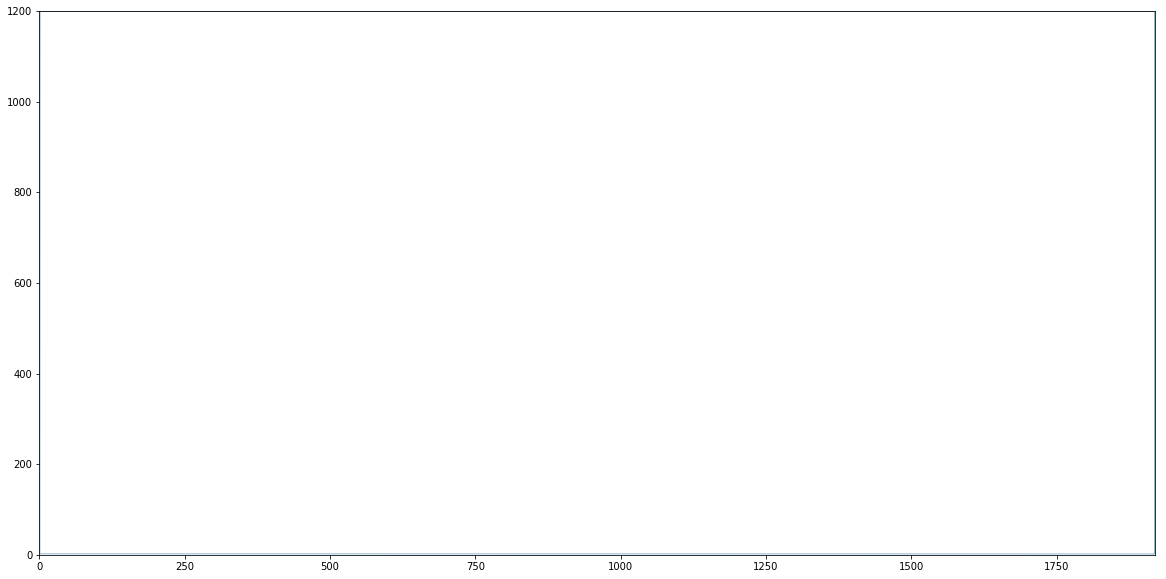

In [335]:
show_edge([contours[0], []])